# Visualizing raster layers

Of course, it is always highly useful to take a look how the data looks like. This is easy with the `plot.show()` -function that comes with rasterio. This can be used to plot a single channel of the data or using mutiple channels simultaniously (multiband). The [channels for the data used in here](https://etsin.avointiede.fi/storage/f/paituli/latuviitta/Landsat_kanavat.pdf) and their corresponding wavelengths are:

 1. Blue (0.45 - 0.515)
 2. Green (0.525 - 0.605)
 3. Red (0.63 - 0.69)
 4. NIR (0.75 - 0.90)
 5. IR (1.55 - 1.75)
 

## Basic plotting


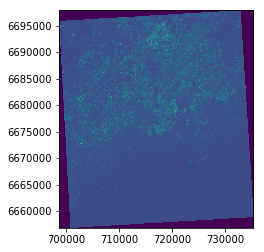

In [43]:
import rasterio
from rasterio.plot import show
import numpy as np
import os

%matplotlib inline

# Data dir
data_dir = "L5_data"

# Filepath
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Plot band 1
show((raster, 1))

Here we can see that the `show` function created a map showing the pixel values of band 1.

Let's see how the different bands look like by placing them next to each other:

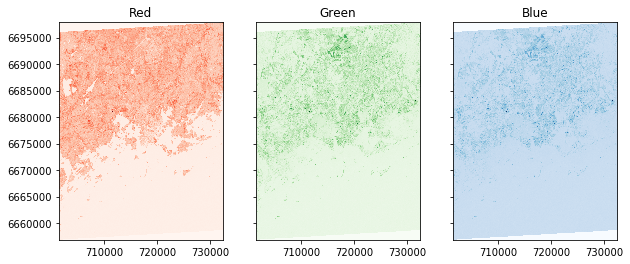

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 4), cmap="Reds", ax=ax1)
show((raster, 3), cmap="Greens", ax=ax2)
show((raster, 1), cmap="Blues", ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

## RGB True color composite

Next let's see how we can plot these channels as a normal RGB image.

- First we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0:

In [41]:
# Read the grid values into numpy arrays
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)


# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)


# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), "-", redn.max(), "mean:", redn.mean())
print(greenn.min(), "-", greenn.max(), "mean:", greenn.mean())
print(bluen.min(), "-", bluen.max(), "mean:", bluen.mean())

Normalized band stats:
0.0 - 1.0 mean: 0.1423301480606746
0.0 - 1.0 mean: 0.16915069862129217
0.0 - 1.0 mean: 0.23384832284425988


As the statistics show, now the arrays have been normalized into scale from 0 to 1. 

- Next we need to stack the values from different values together to produce the RGB true color composite. For this we can use Numpy's [dstack()](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.dstack.html) -function:

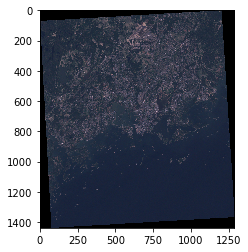

In [51]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

Here we go, now we have a typical RGB natural color composite image that looks like a photograph taken with the satellite. 

## False color composite

Following the previous example, it is easy to create false color composites with different band configurations. 

- One of the typical one, is to replace the blue band with near infra-red that can be used to detect vegetation easily where red color is emphasized. Let's use the same raster file as input, and generate our first false color composite:

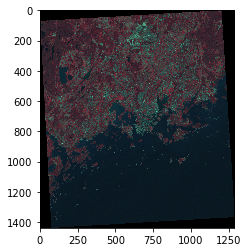

In [52]:
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

As we can see, now the vegetation can be seen more easily from the image (red color).

## Histogram of the raster data

Typically when working with raster data, you want to look at the histogram of different bands in your data. Luckily that is really easy to do with rasterio by using the `plot.show_hist()` function.


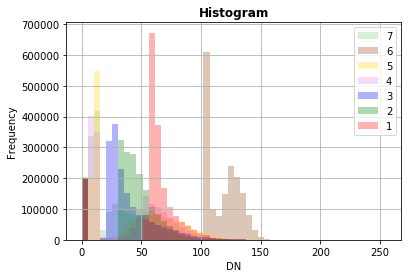

In [32]:
from rasterio.plot import show_hist

show_hist(
    raster,
    bins=50,
    lw=0.0,
    stacked=False,
    alpha=0.3,
    histtype="stepfilled",
    title="Histogram",
)

Now we can easily see how the wavelengths of different bands are distributed.

## Modifying the color map 

TODO: Add explanation. There is a reference to this section from Chapter 7.2 when the hillshade is plotted.

In [1]:
import xarray as xr

# Read the data and calculate relief
url = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS/elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"
data = (
    xr.open_dataset(url, engine="rasterio")
    .squeeze("band", drop=True)
    .rename({"band_data": "elevation"})
)
data["relative_height"] = data["elevation"] - data["elevation"].min().item()

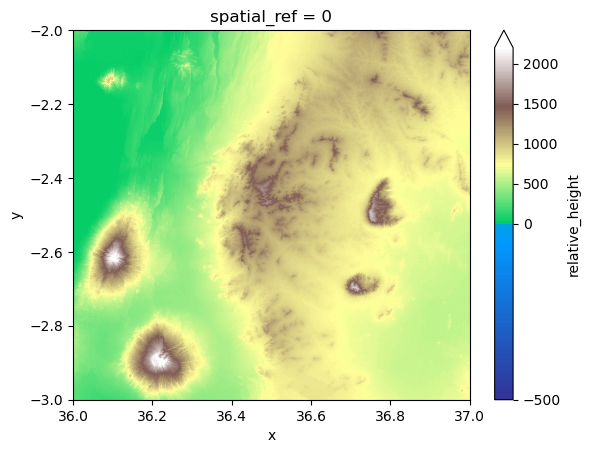

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = colors.LinearSegmentedColormap.from_list("terrain_map", all_colors)
divnorm = colors.TwoSlopeNorm(vmin=-500.0, vcenter=0, vmax=2200)

data["relative_height"].plot(cmap=terrain_map, norm=divnorm)